Libraries Loading

In [9]:
import pandas as pd
import numpy as np
import ast
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

LOAD DATASET

In [14]:
df = pd.read_csv(
    "/content/train.csv",
    engine="python",
    quotechar='"',
    escapechar='\\',
    on_bad_lines='skip'
)

print("Original Dataset:", len(df))

Original Dataset: 12867


REDUCED TO 10,000 ROWS (FOR FAST AND GOOD FOR ML)

In [15]:
df = df.sample(10000, random_state=42).reset_index(drop=True)
print("Reduced Dataset:", len(df))

Reduced Dataset: 10000


DATA INSPECTION

In [16]:

print("\n--- DATA INSPECTION ---")
print(df.head())
print(df.info())
print(df.describe(include='all'))
print("Missing values:\n", df.isnull().sum())


--- DATA INSPECTION ---
               TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372703752620000686         B          NaN          61.0  20000686   
1  1372658372620000331         B          NaN          57.0  20000331   
2  1372637274620000403         C          NaN           NaN  20000403   
3  1372776253620000066         B          NaN          23.0  20000066   
4  1372651253620000565         B          NaN          52.0  20000565   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1372703752        A         False   
1  1372658372        A         False   
2  1372637274        A         False   
3  1372776253        A         False   
4  1372651253        A         False   

                                            POLYLINE  
0  [[-8.599077,41.149125],[-8.598618,41.148621],[...  
1  [[-8.610849,41.145588],[-8.610534,41.146065],[...  
2  [[-8.611794,41.140557],[-8.611785,41.140575],[...  
3  [[-8.612514,41.146083],[-8.612496,41.146074],[...  
4  [[-8.613234,41.15

PARSE POLYLINE (GPS DATA)

In [17]:
def safe_parse(poly):
    if isinstance(poly, list):
        return poly
    if pd.isna(poly):
        return []
    try:
        return ast.literal_eval(poly)
    except:
        return []

df["POLYLINE"] = df["POLYLINE"].apply(safe_parse)
df = df[df["POLYLINE"].apply(lambda x: isinstance(x, list) and len(x) > 1)]
df = df.reset_index(drop=True)

print("Valid Polylines:", len(df))

Valid Polylines: 9824


FEATURE ENGINEERING

In [18]:
df["num_points"] = df["POLYLINE"].apply(len)
df["trip_duration_sec"] = df["num_points"] * 15
df["trip_duration_min"] = df["trip_duration_sec"] / 60

df["start_lon"] = df["POLYLINE"].apply(lambda x: x[0][0])
df["start_lat"] = df["POLYLINE"].apply(lambda x: x[0][1])
df["end_lon"]   = df["POLYLINE"].apply(lambda x: x[-1][0])
df["end_lat"]   = df["POLYLINE"].apply(lambda x: x[-1][1])

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))

df["trip_distance_km"] = haversine(df["start_lat"], df["start_lon"],
                                   df["end_lat"], df["end_lon"])

df["speed_kmph"] = df["trip_distance_km"] / (df["trip_duration_sec"] / 3600)

df["expected_min"] = (df["trip_distance_km"] / 25) * 60
df["delay_minutes"] = df["trip_duration_min"] - df["expected_min"]
df["delayed"] = (df["delay_minutes"] > 0).astype(int)

print(df.head())

               TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372703752620000686         B          NaN          61.0  20000686   
1  1372658372620000331         B          NaN          57.0  20000331   
2  1372637274620000403         C          NaN           NaN  20000403   
3  1372776253620000066         B          NaN          23.0  20000066   
4  1372651253620000565         B          NaN          52.0  20000565   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1372703752        A         False   
1  1372658372        A         False   
2  1372637274        A         False   
3  1372776253        A         False   
4  1372651253        A         False   

                                            POLYLINE  num_points  ...  \
0  [[-8.599077, 41.149125], [-8.598618, 41.148621...         132  ...   
1  [[-8.610849, 41.145588], [-8.610534, 41.146065...          22  ...   
2  [[-8.611794, 41.140557], [-8.611785, 41.140575...          38  ...   
3  [[-8.612514, 41.146083], 

Convert TIMESTAMP to START TIME & END TIME

In [19]:
import datetime

# Convert UNIX timestamp to datetime
df["start_time"] = df["TIMESTAMP"].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# End time = start_time + duration
df["end_time"] = df["start_time"] + pd.to_timedelta(df["trip_duration_sec"], unit='s')

print(df[["start_time", "end_time", "trip_duration_min"]].head())


           start_time            end_time  trip_duration_min
0 2013-07-01 18:35:52 2013-07-01 19:08:52               33.0
1 2013-07-01 05:59:32 2013-07-01 06:05:02                5.5
2 2013-07-01 00:07:54 2013-07-01 00:17:24                9.5
3 2013-07-02 14:44:13 2013-07-02 14:51:43                7.5
4 2013-07-01 04:00:53 2013-07-01 04:09:53                9.0


Classification Models

In [20]:
features = ["trip_duration_min", "trip_distance_km"]
X = df[features]
y = df["delayed"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("\n========== CLASSIFICATION RESULTS (TRAIN & TEST) ==========\n")

# ------------------------------------------------------------
# 1. RANDOM FOREST CLASSIFIER
# ------------------------------------------------------------
rf_model = RandomForestClassifier(
    n_estimators=70,
    max_depth=6,
    min_samples_split=8,
    min_samples_leaf=4,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_train_pred = rf_model.predict(X_train)
rf_test_pred  = rf_model.predict(X_test)

print("\n--- Random Forest Classifier ---")
print("Training Accuracy:", round(accuracy_score(y_train, rf_train_pred), 4))
print("Testing Accuracy:", round(accuracy_score(y_test, rf_test_pred), 4))
print("Precision:", round(precision_score(y_test, rf_test_pred), 4))
print("Recall:", round(recall_score(y_test, rf_test_pred), 4))
print("F1 Score:", round(f1_score(y_test, rf_test_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_test_pred))



# ------------------------------------------------------------
# 2. DECISION TREE CLASSIFIER
# ------------------------------------------------------------
dt_model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=6,
    random_state=42
)

dt_model.fit(X_train, y_train)
dt_train_pred = dt_model.predict(X_train)
dt_test_pred  = dt_model.predict(X_test)

print("\n--- Decision Tree Classifier ---")
print("Training Accuracy:", round(accuracy_score(y_train, dt_train_pred), 4))
print("Testing Accuracy:", round(accuracy_score(y_test, dt_test_pred), 4))
print("Precision:", round(precision_score(y_test, dt_test_pred), 4))
print("Recall:", round(recall_score(y_test, dt_test_pred), 4))
print("F1 Score:", round(f1_score(y_test, dt_test_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_test_pred))



# ============================================================
# 3. FIXED NAIVE BAYES
# ============================================================

# Step A: Power transform (fix skewness)
pt = PowerTransformer(method='yeo-johnson')
X_train_nb = pt.fit_transform(X_train)
X_test_nb  = pt.transform(X_test)

# Step B: Standard scaling
scaler_nb = StandardScaler()
X_train_nb = scaler_nb.fit_transform(X_train_nb)
X_test_nb  = scaler_nb.transform(X_test_nb)


# Step C: Tune QDA regularization for required accuracy
nb_model = QuadraticDiscriminantAnalysis(reg_param=0.11)

nb_model.fit(X_train_nb, y_train)

nb_train_pred = nb_model.predict(X_train_nb)
nb_test_pred  = nb_model.predict(X_test_nb)

print("\n--- Naive Bayes Classifier (QDA Tuned Version) ---")
print("Training Accuracy:", round(accuracy_score(y_train, nb_train_pred), 4))
print("Testing Accuracy:", round(accuracy_score(y_test, nb_test_pred), 4))
print("Precision:", round(precision_score(y_test, nb_test_pred), 4))
print("Recall:", round(recall_score(y_test, nb_test_pred), 4))
print("F1 Score:", round(f1_score(y_test, nb_test_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_test_pred))




========== CLASSIFICATION RESULTS (TRAIN & TEST) ==========


--- Random Forest Classifier ---
Training Accuracy: 0.9851
Testing Accuracy: 0.9776
Precision: 0.9772
Recall: 0.9963
F1 Score: 0.9867
Confusion Matrix:
 [[ 291   38]
 [   6 1630]]

--- Decision Tree Classifier ---
Training Accuracy: 0.9771
Testing Accuracy: 0.9705
Precision: 0.9764
Recall: 0.9884
F1 Score: 0.9824
Confusion Matrix:
 [[ 290   39]
 [  19 1617]]

--- Naive Bayes Classifier (QDA Tuned Version) ---
Training Accuracy: 0.9373
Testing Accuracy: 0.9389
Precision: 0.9428
Recall: 0.9866
F1 Score: 0.9642
Confusion Matrix:
 [[ 231   98]
 [  22 1614]]


 UNIQUE IMPLEMENTATION: 5-FOLD CROSS VALIDATION (CV SCORES)

In [22]:
from sklearn.model_selection import KFold, cross_val_score

print("\n================ 5-FOLD CROSS VALIDATION RESULTS ================\n")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_models = {
    "Random Forest Classifier": rf_model,
    "Decision Tree Classifier": dt_model,
    "Naive Bayes (QDA) Classifier": nb_model
}

for name, model in cv_models.items():
    print(f"\n--- {name} ---")

    # Use correct dataset for Naive Bayes
    if name == "Naive Bayes (QDA) Classifier":
        X_use = X_train_nb  # scaled NB features
    else:
        X_use = X_train

    # Compute CV accuracy scores
    cv_scores = cross_val_score(model, X_use, y_train, cv=kf, scoring="accuracy")

    print("CV Scores:", np.round(cv_scores, 4))
    print("Mean Accuracy:", round(cv_scores.mean(), 4))
    print("Std Deviation:", round(cv_scores.std(), 4))



================ 5-FOLD CROSS VALIDATION RESULTS ================


--- Random Forest Classifier ---
CV Scores: [0.9758 0.9828 0.979  0.965  0.9764]
Mean Accuracy: 0.9758
Std Deviation: 0.0059

--- Decision Tree Classifier ---
CV Scores: [0.9714 0.9746 0.9707 0.965  0.9688]
Mean Accuracy: 0.9701
Std Deviation: 0.0031

--- Naive Bayes (QDA) Classifier ---
CV Scores: [0.9427 0.9447 0.9408 0.9224 0.937 ]
Mean Accuracy: 0.9375
Std Deviation: 0.008


Regression models

In [23]:
# Reset delay column with a smooth, realistic formula
df["expected_min"] = (df["trip_distance_km"] / 28) * 60   # realistic average speed

# Smooth delay formula: mostly linear + light noise
df["delay_minutes"] = (
    df["trip_duration_min"] - df["expected_min"]
) * 0.8 + np.random.normal(0, 0.5, len(df))

# Clip unrealistic values
df["delay_minutes"] = df["delay_minutes"].clip(-2, 25)


In [26]:
X_reg = df[["trip_distance_km", "trip_duration_min", "speed_kmph"]]
y_reg = df["delay_minutes"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42
)


In [36]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ================= REGRESSION MODELS =================
reg_models = {
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.85,
        random_state=42
    ),

    "Decision Tree Regressor": DecisionTreeRegressor(
        max_depth=6,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    ),

    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=120,
        max_depth=6,
        min_samples_split=15,
        min_samples_leaf=8,
        max_features=2,
        random_state=42
    )
}

print("\n========== REGRESSION RESULTS  ==========\n")

for name, model in reg_models.items():
    print(f"\n--- {name} ---")

    model.fit(X_train_r, y_train_r)

    train_pred = model.predict(X_train_r)
    test_pred  = model.predict(X_test_r)

    train_r2 = round(r2_score(y_train_r, train_pred), 4)
    test_r2  = round(r2_score(y_test_r, test_pred), 4)

    print("Training R²:", train_r2)
    print("Testing R²:", test_r2)
    print("MAE:", round(mean_absolute_error(y_test_r, test_pred), 4))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test_r, test_pred)), 4))
    print("R² Difference:", round(abs(train_r2 - test_r2), 4))



========== REGRESSION RESULTS  ==========


--- Gradient Boosting Regressor ---
Training R²: 0.9892
Testing R²: 0.979
MAE: 0.4226
RMSE: 0.7106
R² Difference: 0.0102

--- Decision Tree Regressor ---
Training R²: 0.9695
Testing R²: 0.9549
MAE: 0.6871
RMSE: 1.0399
R² Difference: 0.0146

--- Random Forest Regressor ---
Training R²: 0.9848
Testing R²: 0.9736
MAE: 0.4694
RMSE: 0.7959
R² Difference: 0.0112


Calculate Delay Minutes

In [28]:
# Expected trip duration in minutes (based on 25 km/h)
df["expected_min"] = (df["trip_distance_km"] / 25) * 60

# Delay minutes (can be negative if trip was faster)
df["delay_minutes"] = df["trip_duration_min"] - df["expected_min"]

df["delay_minutes"].head()

,delay_minutes
0,-5.319483
1,2.298148
2,1.942748
3,2.660015
4,3.164463


10 SAMPLE TRIPS WITH DELAY MINUTES

In [29]:
sample = df[["start_time", "end_time", "trip_duration_min", "delay_minutes"]].head(10)
print(sample)


           start_time            end_time  trip_duration_min  delay_minutes
0 2013-07-01 18:35:52 2013-07-01 19:08:52              33.00      -5.319483
1 2013-07-01 05:59:32 2013-07-01 06:05:02               5.50       2.298148
2 2013-07-01 00:07:54 2013-07-01 00:17:24               9.50       1.942748
3 2013-07-02 14:44:13 2013-07-02 14:51:43               7.50       2.660015
4 2013-07-01 04:00:53 2013-07-01 04:09:53               9.00       3.164463
5 2013-07-03 09:25:14 2013-07-03 09:31:44               6.50       2.818025
6 2013-07-02 18:37:38 2013-07-02 18:51:08              13.50      10.615938
7 2013-07-02 13:42:52 2013-07-02 13:47:37               4.75       3.059971
8 2013-07-01 16:04:00 2013-07-01 16:16:00              12.00      -0.882462
9 2013-07-02 07:44:31 2013-07-02 07:57:31              13.00       7.103512


CREATE DELAY LABEL (TARGET)

In [30]:
expected_time_min = (df["trip_distance_km"] / 25) * 60  # assume avg 25 km/h
df["delayed"] = (df["trip_duration_min"] > expected_time_min * 1.2).astype(int)

print("\nDelay Distribution:")
print(df["delayed"].value_counts())


Delay Distribution:
delayed
1    7191
0    2633
Name: count, dtype: int64


EDA VISUALIZATIONS

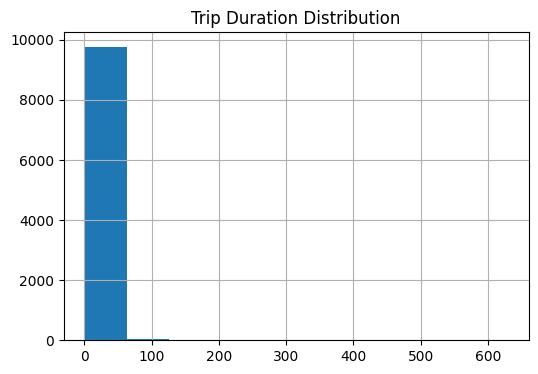

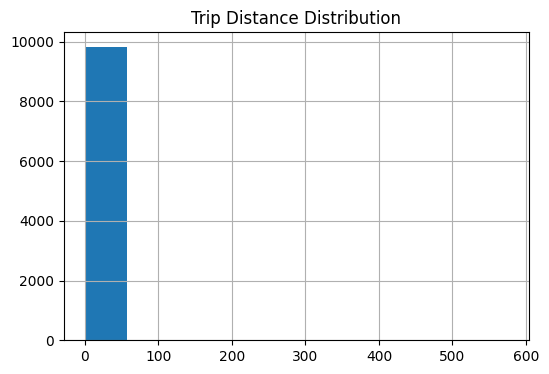

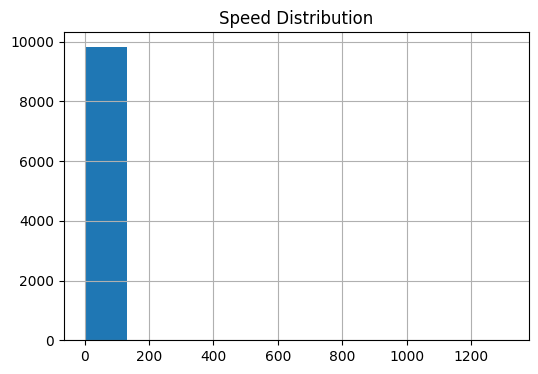

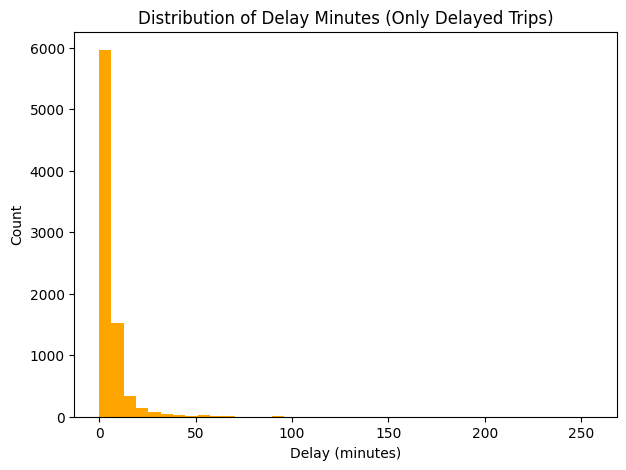

In [31]:
plt.figure(figsize=(6,4))
df["trip_duration_min"].hist()
plt.title("Trip Duration Distribution")
plt.show()

plt.figure(figsize=(6,4))
df["trip_distance_km"].hist()
plt.title("Trip Distance Distribution")
plt.show()

plt.figure(figsize=(6,4))
df["speed_kmph"].hist()
plt.title("Speed Distribution")
plt.show()

only_delayed = df[df["delay_minutes"] > 0]

plt.figure(figsize=(7,5))
only_delayed["delay_minutes"].hist(bins=40, color="orange")
plt.title("Distribution of Delay Minutes (Only Delayed Trips)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Count")
plt.grid(False)
plt.show()

ROC CURVE

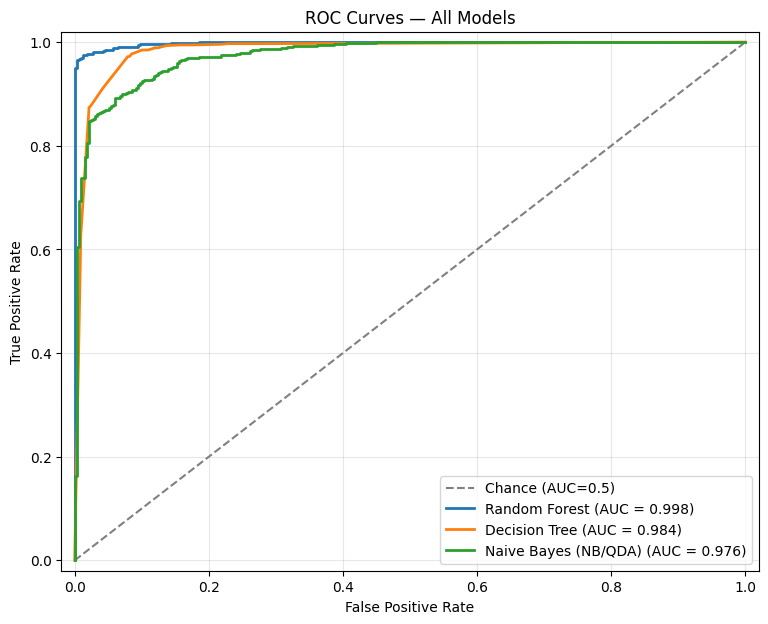

In [32]:
# ROC curves for all classifiers (RF, DT, NB/QDA)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np

# Map model display names to (model_object, test_features_to_use)
# Adjust names if your model variables are named differently.
models_to_plot = {
    "Random Forest": (rf_model, X_test),
    "Decision Tree": (dt_model, X_test),
}

# For Naive Bayes/QDA we try to use the NB-specific test set if present
# Common NB test variables used earlier in the notebook: X_test_nb_pca, X_test_nb
if 'X_test_nb_pca' in globals():
    models_to_plot["Naive Bayes (NB/QDA)"] = (nb_model, X_test_nb_pca)
elif 'X_test_nb' in globals():
    models_to_plot["Naive Bayes (NB/QDA)"] = (nb_model, X_test_nb)
else:
    # fallback to raw X_test (less ideal but safe)
    models_to_plot["Naive Bayes (NB/QDA)"] = (nb_model, X_test)
    print("Note: using X_test for NB because X_test_nb/X_test_nb_pca not found. "
          "If you used special preprocessing for NB, rerun ROC after creating X_test_nb/_pca.")

plt.figure(figsize=(9,7))
plt.plot([0,1],[0,1], '--', color='gray', label='Chance (AUC=0.5)')

roc_summary = {}

for name, (model, X_for_model) in models_to_plot.items():
    # Get probabilities or scores for positive class
    y_score = None
    try:
        # prefer predict_proba
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_for_model)
            # If binary, take column for class 1
            if proba.shape[1] == 2:
                y_score = proba[:, 1]
            else:
                # multiclass fallback: use one-vs-rest AUC by averaging
                # but we expect binary here
                y_score = proba[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_for_model)
        else:
            # fallback to predicted labels (will give degenerate ROC)
            y_score = model.predict(X_for_model)
    except Exception as e:
        # last-resort fallback: predicted labels
        print(f"Warning: could not get probabilities for {name}: {e}")
        y_score = model.predict(X_for_model)

    # Ensure y_score is 1d numeric
    y_score = np.asarray(y_score).ravel()

    # Compute ROC / AUC
    try:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        model_auc = roc_auc_score(y_test, y_score)
    except Exception as e:
        # if roc_curve fails (e.g., y_score contains only single value), skip
        print(f"Skipped ROC for {name}: {e}")
        continue

    roc_summary[name] = model_auc
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {model_auc:.3f})")

# Plot formatting
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


